## AdaBoost
* This kernel attempt to produce simplest possible pure python implementation of AdaBoost, using sklearn's Decision Tree as base learner.<br>
* Despite the simplicity, performance seems to be on par with Scikit-learn's official implementation, at least on simple datasets tested here.

In [1]:
import os
from collections import defaultdict
from time import perf_counter

import numpy as np # linear algebra
np.random.seed(42)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv
from sklearn.datasets import load_breast_cancer,load_iris,load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble.weight_boosting import ClassifierMixin,BaseEnsemble
from sklearn.model_selection import train_test_split,cross_validate,RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns


Lets prepare our dataset first. This will be classic Iris dataset, but now both sepal_* features dropped, to bring the dataset to 2D for visualization. Sepal features are relatively less important in Iris dataset. Besides maximizing accuracy isn't the goal of this notebook.

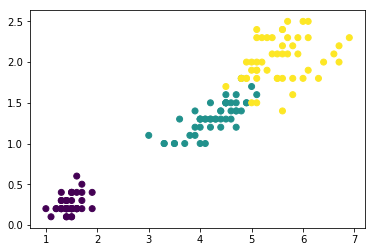

In [2]:
iris = load_iris()
Xiris,Yiris= iris.data[:,2:],iris.target
plt.scatter(Xiris[:,0],Xiris[:,1],c=Yiris);

# AdaBoost
* Initialize all training samples with equal weight (sum to 1) (array `Wt` below)
* For `T` no of rounds, create `T` of models, weight of each model is proportional to its performance
* During prediction, class with highest (weighted) votes from trained models will be chosen.

In [3]:
T = 50                 #Total number of training rounds
X,Y = Xiris,Yiris       #Using whole dataset for training for now

n_classes = len(np.unique((Y))) #No of classes to predict
N,M = X.shape           #Training and feature size respectively 
Wt = np.full((N,),1/N)  #weight of training samples, all initially equal. This will always sum to 1
models = []             #Store trained models

## Fitting the model : A single iteration
* Build a new training set by sampling from original set, according to instance-weight `Wt`
* Fit a simple Decision Tree Classifier (of small depth) with the new training set
* Predict class labels for whole training set using trained model
* Increase the weights of misclassified instances, decrease for the correctly classified ones
* We also log different information in `log` dictionary below

In [4]:
log = defaultdict(list)
for t in range(T):
    """Train & predict with Base Classifier (Decision Tree here)"""
    clf = DecisionTreeClassifier(max_depth=1).fit(X,Y,sample_weight=Wt)
    preds = clf.predict(X)
    e = 1 - accuracy_score(Y,preds,sample_weight=Wt)            
    if e==0 or e>= 1 - 1/n_classes : # Discard too weak classifiers 
        break
        
    """Change a instance-weight based on if it was correctly classified"""
    alpha = np.log((1-e)/e) + np.log(n_classes - 1)       #Weight of the newly trained tree
    match = preds==Y                 #Find indices of correctly classified instances 
    Wt[~match] *= np.exp(alpha)      #Increase weight of mis-classified instances
    Wt /= Wt.sum()                   #Normalize the weights to sum upto 1
    models.append((alpha,clf))       #Store the newly trained model (clf) and its weight (alpha)
    
    """Log several training info for further analysis"""
    log['err'].append(e)             #Log weighted error
    log['alpha'].append(alpha)       #Log tree weights
    log['match'].append(match.sum()) #Log total no of instances correctly classified, related to log['e']
    log['ins-weight'].append(Wt.copy())   #Log instance-weights

m = len(models)
print("Total models trained:",m)

Total models trained: 50


Sometimes, few classifiers may fail to achieve the minimum accuracy for it to be included into final classifier. This can be atrributed to extreme simplicity of base classifier.

Below, we plot the logged information and see what they reveal.

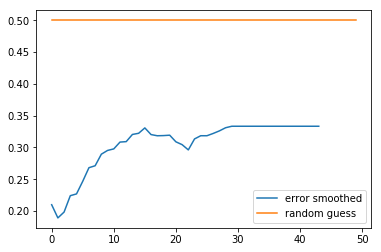

In [5]:
def smooth(a):
    """Helper to smooth curves"""
    return np.convolve(a,[1,1,1,1,1,1,1],'valid') / 7

plt.plot(smooth(log['err']),label='error smoothed')    # Smoothed error of trained models
plt.plot([.5]*m,label='random guess');                 # Vs a random classifier
plt.legend(loc="best");


The plot above shows that latter models struggle more to classify compared to earlier models. The plateau at the end suggests we could do with fewer trees.
This comparatively poorer performance naturally corresponds to lower weights for latter models, as the plot below shows.

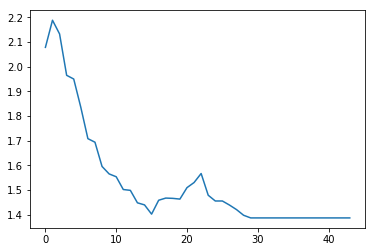

In [6]:
plt.plot(smooth(log['alpha']));

But why does latter models struggle more? The answer lies in instance weight distrbution, which gradually focuses more on harder instances, at the expanse of easier ones. This means relative weights among instances, as calculated by standard deviation here, also gradually increase.

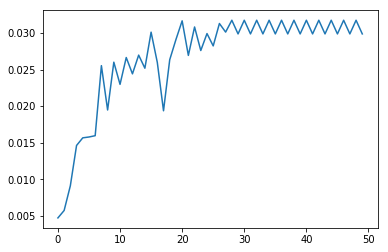

In [7]:
plt.plot([w.std() for w in log['ins-weight']]);

Now, lets see where are the top 20 hardest instances of our training set. 

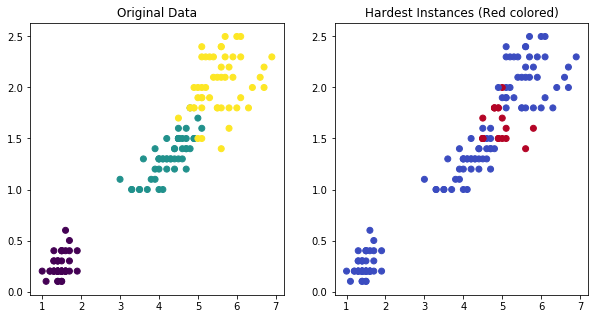

In [8]:
idx = np.argsort(-Wt)[:20]
top_10 = np.zeros_like(Wt)
top_10[idx] = 1.0

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(Xiris[:,0],Xiris[:,1],c=Yiris);
plt.title("Original Data")

plt.subplot(122)
plt.scatter(X[:,0],X[:,1],c=top_10,cmap=plt.cm.coolwarm,);
plt.title("Hardest Instances (Red colored)");



Not surprisingly, hardest instances are all near the decision boundary or the outliers.

**This is the reason behind AdaBoost's performance, it starts with learning to classify simpler instances, and then gradually shifts attention towards harder ones, ones previuos models performed poorly on. So in the final ensemble of trained models, we have both models that perform great with simple instances, and the ones that work well mainly for harder instances.  **

## Predicting 
* Take weighted predictions from each trained model
* Find the class with highest votes 


In [9]:
N = len(X)
Ypred = np.zeros((N,n_classes))
for alpha,clf in models:
    yp = clf.predict(X)
    Ypred[range(N),yp] += alpha
Ypred = np.argmax(Ypred,axis=1)  #Final prediction is `Ypred`


## Putting It All Together
(Please expand the code below for complete code in sklearn-like API)

In [10]:
class SimpleAdaBoost(BaseEstimator,ClassifierMixin):  #Inheritance is to allow using sklearn's cross_validate on this
    def __init__(self,T=50,max_tree_depth=1):
        self.T = T
        self.models = []
        self.max_tree_depth = max_tree_depth

    def fit(self,X,Y):
        self.n_classes = len(np.unique(Y))  
        self.models = []               #Throw away if there are trained models from any previous fit()
        N = len(X)
        Wt = np.full((N,),1/N)
        for t in range(self.T):
            clf = DecisionTreeClassifier(max_depth=self.max_tree_depth).fit(X,Y,sample_weight=Wt)
            preds = clf.predict(X)
            e = 1 - accuracy_score(Y,preds,sample_weight=Wt)
            if e==0 or e>= 1-1/self.n_classes:
                break
            alpha = np.log((1-e)/e) + np.log(self.n_classes - 1)
            match = preds==Y
            Wt[~match] *= np.exp(alpha)
            Wt /= Wt.sum()
            self.models.append((alpha,clf))
        return self

    def predict(self,X,start=0,end=99999):
        N = len(X)
        Ypred = np.zeros((N,self.n_classes))        
        for alpha,clf in self.models[start:end]:
            yp = clf.predict(X)
            Ypred[range(N),yp] += alpha
        return np.argmax(Ypred,axis=1)

Now we'll see how the decision boundary of our `SimpleAdaBoost` changes as more base learners are added to it...

In [11]:
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation

xp = np.arange(Xiris[:,0].min()-1,Xiris[:,0].max()+1,.02)
yp = np.arange(Xiris[:,1].min()-1,Xiris[:,1].max()+1,.02)
xx,yy = np.meshgrid(xp,yp) 

fig, ax = plt.subplots()
plt.close()
clf = SimpleAdaBoost(T=30,max_tree_depth=2).fit(Xiris,Yiris)
m = len(clf.models)
print(m)

individual = False     #Change this to True if you want to just visualize the individual tree boundaries
def animate(i):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()],start=individual and i,end=i+1).reshape(xx.shape)
    ax.contourf(xx,yy,Z,cmap=plt.cm.coolwarm,alpha=.99);
    ax.scatter(Xiris[:,0],Xiris[:,1],c=Yiris);
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=m,interval=400)
ani

30


## Testing Our Implementation
* Against Sklearn's AdaBoost and our base learner i.e. DecisionTreeClassifier.
* On 4 different datasets, Breast Cancer Wisconsin, Pima Indians Diabetes dataset, Iris and Digits.

First, lets write a helper to evaluate a model.

In [12]:
def validate(model,X,Y,rounds=100):
    start = perf_counter()
    acc = cross_validate(model,X,Y,cv=RepeatedStratifiedKFold(n_repeats=10))['test_score'].mean()
    end = perf_counter()
    print(f"{model.__class__.__name__} : {acc*100:.1f} % in {end-start:.2f} seconds")

Now lets start eveluations.`SimpleAdaBoost` is our implemented AdaBoost, `AdaBoostClassifier` is scikit-learn's official implementation. We also include base learner Decision Tree here, to see how much boost in performace came from these AdaBoosts.

In [13]:
"""Diabetes Dataset """
df = pd.read_csv("../input/pima-indians-diabetes-database/diabetes.csv")
Xdiab,Ydiab = df.values[:,:-1],df.values[:,-1].astype('int32')

validate(SimpleAdaBoost(),Xdiab,Ydiab)
validate(AdaBoostClassifier(algorithm='SAMME'),Xdiab,Ydiab)
validate(DecisionTreeClassifier(),Xdiab,Ydiab);

SimpleAdaBoost : 75.5 % in 3.09 seconds
AdaBoostClassifier : 75.8 % in 3.26 seconds
DecisionTreeClassifier : 70.2 % in 0.19 seconds


In [14]:
"""Breast Cancer Dataset """
Xcan,Ycan = load_breast_cancer(return_X_y=True)
validate(SimpleAdaBoost(),Xcan,Ycan);validate(AdaBoostClassifier(algorithm='SAMME'),Xcan,Ycan),validate(DecisionTreeClassifier(),Xcan,Ycan);

SimpleAdaBoost : 96.7 % in 5.65 seconds
AdaBoostClassifier : 96.5 % in 5.95 seconds
DecisionTreeClassifier : 92.7 % in 0.40 seconds


In [15]:
"""Full Iris Dataset """
Xiris,Yiris = load_iris(return_X_y=True)
validate(SimpleAdaBoost(max_tree_depth=3),Xiris,Yiris)
validate(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),algorithm='SAMME'),Xiris,Yiris)
validate(DecisionTreeClassifier(),Xiris,Yiris);

SimpleAdaBoost : 95.3 % in 1.21 seconds
AdaBoostClassifier : 95.0 % in 1.69 seconds
DecisionTreeClassifier : 94.4 % in 0.06 seconds


In [16]:
"""Digits Dataset """
Xdig,Ydig = load_digits(return_X_y=True)
validate(SimpleAdaBoost(max_tree_depth=3,T=100),Xdig,Ydig)
validate(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),n_estimators=100,algorithm='SAMME'),Xdig,Ydig)
validate(DecisionTreeClassifier(),Xdig,Ydig);

SimpleAdaBoost : 94.4 % in 40.40 seconds
AdaBoostClassifier : 94.1 % in 38.12 seconds
DecisionTreeClassifier : 85.0 % in 1.05 seconds


Thats it.<br> 
Thank you for reading this kernel. <br> 
Any feedback is welcome.